# Kodak ColorPlus 200

Notebook for extracting film pigment and experimenting with layers to get the right balancing.

## Film Pigment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

In [2]:
film_image = "Films/COLOR_PLUS_200.png"

### Load film image & preprocess

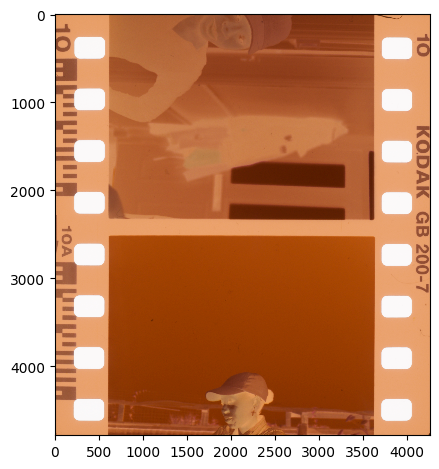

In [3]:
image = ski.util.img_as_float64(ski.io.imread(film_image))
ski.io.imshow(image)

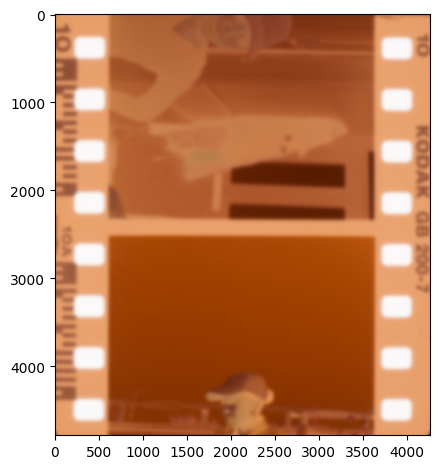

In [4]:
blurred = ski.filters.gaussian(image, sigma=(20, 20), channel_axis=-1)
ski.io.imshow(blurred)

### Obtain colour distribution

In [5]:
distribution, edges = np.histogramdd(blurred.reshape(-1, 3), bins=256, range=[(0,1), (0,1), (0, 1)],)

In [6]:
LIMIT_COLOURS = 50

sorted_count = np.sort(distribution, axis=None)[-LIMIT_COLOURS:]
indices = np.argsort(distribution, axis=None)[-LIMIT_COLOURS:]

sorted_colours = np.array(np.unravel_index(indices, shape=distribution.shape)).T
by_intensity = np.linalg.norm(sorted_colours, axis=1).argsort()

sorted_count_by_intensity = sorted_count[by_intensity]
sorted_colours_by_intensity = sorted_colours[by_intensity]

### Select `white` and `emulsion` colours

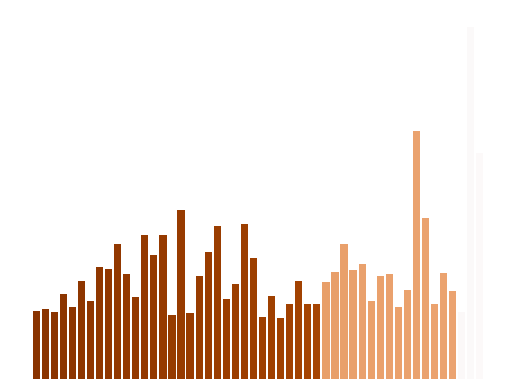

In [7]:
plt.bar(np.arange(LIMIT_COLOURS) + 1, sorted_count_by_intensity[-LIMIT_COLOURS:], color=sorted_colours_by_intensity[-LIMIT_COLOURS:] / 255)
plt.axis("off")
plt.show()

In [ ]:
white = sorted_colours_by_intensity[-1]
emulsion = sorted_colours_by_intensity[-5]

print(f"White value: {tuple(white.tolist())}")
print(f"Emulsion value: {tuple(emulsion.tolist())}")

NameError: name 'sorted_colours_by_intensity' is not defined

: 

### Preprocess `emulsion` to get pigment

In [20]:
from nevernegative.layers.balancing.temperature import Temperature

pigment = (emulsion * 255 / white).astype(np.uint8)
temperature = Temperature.infer_temperature(white)

print(f"Pigment value: {tuple(pigment.tolist())}")
print(f"Estimated white temperature: {temperature:.0f}K.")


NameError: name 'emulsion' is not defined

(np.float64(-0.5), np.float64(4263.5), np.float64(4783.5), np.float64(-0.5))

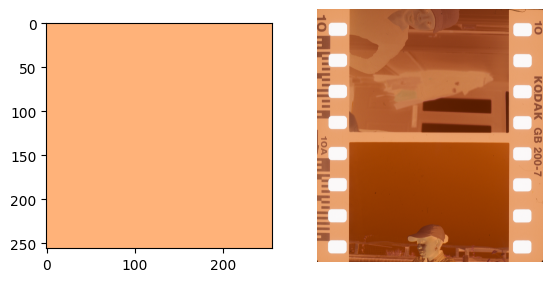

In [70]:
pigment_image = np.empty((256, 256, 3), dtype=np.uint8)
pigment_image[:, :] = pigment

figure, axes = plt.subplots(1, 2)
[pigment_axis, image_axis] = axes.ravel()

pigment_axis.imshow(pigment_image)
image_axis.imshow(image)

plt.axis("off")

## Layers

In [1]:
from pathlib import Path
from nevernegative.layers.utils.resize import Resize
from nevernegative.scanner.simple import SimpleScanner
import matplotlib.pyplot as plt

In [2]:
images_folder = "/Users/louismanestar/Documents/Projects/Film Scanner/nevernegative/images/Brighton"
glob = "*.NEF"

### V1: Constrast Stretching

In [17]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.contrast_stretch import ContrastStretch
from nevernegative.layers.utils.clip import Clip
from nevernegative.layers.balancing.invert import Invert

layers = [
    Invert(),
    ContrastStretch((0.01, 0.99), per_channel=True, mode="mean"),
    Gamma(1.3, channel=2),
    Clip(),
]

### V1: Means Matching

In [ ]:
from nevernegative.layers.balancing.gamma import Gamma
from nevernegative.layers.balancing.match_means import MatchMeans
from nevernegative.layers.balancing.shift import ShiftBound
from nevernegative.layers.balancing.invert import Invert

layers = [
    Invert(),
    MatchMeans(0, 1),
    MatchMeans(2, 1),
    ShiftBound(0.01, value=0.05),
    Gamma(0.9),
]

### V2: Removing Emulsion Pigment

In [14]:
from nevernegative.layers.balancing.brightness import Brightness
from nevernegative.layers.balancing.contrast import Contrast
from nevernegative.layers.balancing.pigment import RemoveEmulsionPigment
from nevernegative.layers.balancing.saturation import Saturation
from nevernegative.layers.balancing.temperature import Temperature
from nevernegative.layers.balancing.invert import Invert

layers = [
    # Temperature(temperature=5600),
    RemoveEmulsionPigment(pigment=(235, 163, 111)),
    Invert(),
    Brightness(0.82, channel=0),
    Brightness(0.6, channel=1),
    Brightness(0.49, channel=2),
    Contrast(2.7),
    Brightness(1.2),
    Saturation(1),
]

### Testing Layers

#### Single Image

(np.float64(-0.5), np.float64(598.5), np.float64(399.5), np.float64(-0.5))

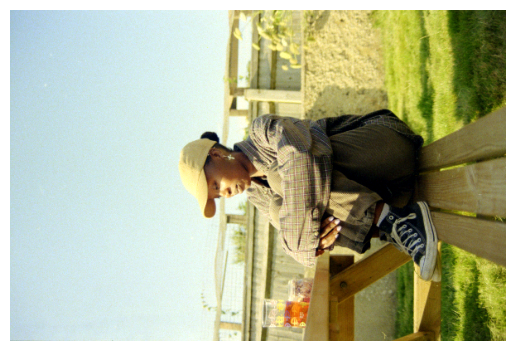

In [19]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

filename = "DSC_1020.NEF"
output_path = Path("results/colorplus/")

processed = scanner.file(
    source=Path(images_folder) / filename,
    destination=Path("results/colorplus/"),
    is_raw=True,
    plot_path=output_path
)

plt.imshow(processed.permute(1, 2, 0).cpu().numpy())
plt.axis("off")

In [16]:
scanner = SimpleScanner([Resize(height=400), *layers], device="mps")

scanner.glob(
    source=(Path(images_folder) / glob).as_posix(),
    destination=Path("test_images/colorplus"),
    is_raw=True,
)

Proccesing images: 100%|██████████| 36/36 [01:32<00:00,  2.56s/it]
